In [47]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Define a deeper network
class DeepNetwork(nn.Module):
    def __init__(self):
        super(DeepNetwork, self).__init__()
        self.fc1 = nn.Linear(1, 10)  # First layer
        self.fc2 = nn.Linear(10, 10)  # Second layer
        self.fc3 = nn.Linear(10, 10)  # Third layer
        self.fc4 = nn.Linear(10, 10)  # Fourth layer
        self.fc5 = nn.Linear(10, 1)  # Fifth layer
        self.activation = nn.Sigmoid()  # Sigmoid activation
        self.x1 = 0

    def forward(self, x):
        self.x1 = self.fc1(x)
        x = self.activation(self.x1)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.fc4(x)
        x = self.activation(x)
        x = self.fc5(x)
        x = self.activation(x)
        return x

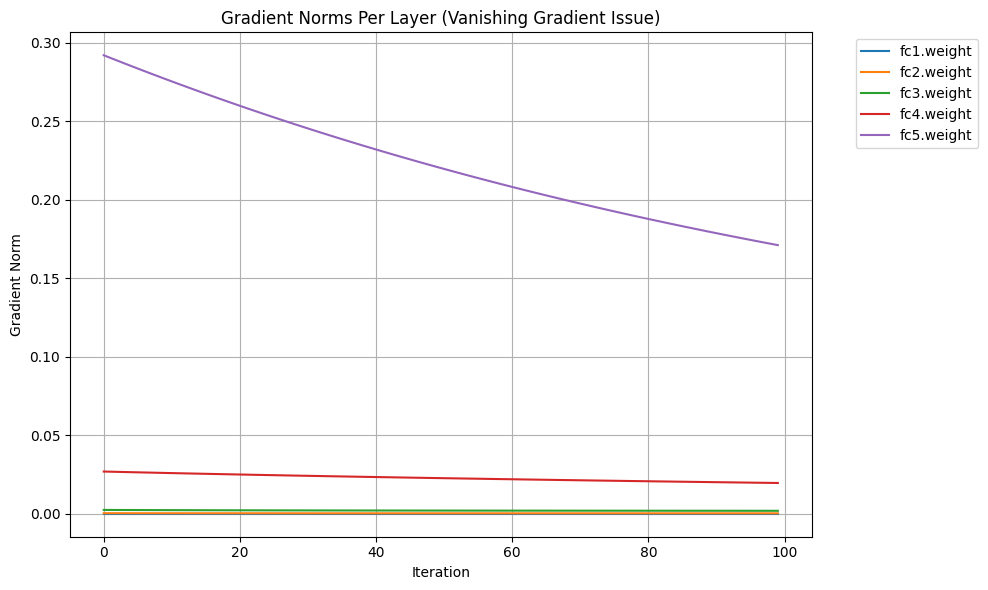

In [48]:
# Initialize the network and loss function
model = DeepNetwork()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Data: input values that lead to saturated sigmoid activation
x_train = torch.full((1, 1), 100.0, requires_grad=True)  # Large input leads to sigmoid saturation
y_train = torch.tensor([[0.0]])  # Target

# Store gradient norms for each layer
gradient_norms = {name: [] for name, _ in model.named_parameters() if not "bias" in name}

# Training loop
for iteration in range(100):
    # Forward pass
    optimizer.zero_grad()
    output = model(x_train)
    loss = criterion(output, y_train)

    # Backward pass
    loss.backward()
    
    # Record gradient norm for each layer
    for name, param in model.named_parameters():
        if "bias" in name: continue
        if param.grad is not None:
            gradient_norms[name].append(param.grad.norm(2).item())

    # Update weights
    optimizer.step()

# Plot the gradient norms for each layer
plt.figure(figsize=(10, 6))
for name, norms in gradient_norms.items():
    plt.plot(range(100), norms, label=name)

plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norms Per Layer (Vanishing Gradient Issue)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

In [49]:
for key,values in gradient_norms.items():
    print(key, values[0])

fc1.weight 3.459450725884494e-09
fc2.weight 0.0003854125097859651
fc3.weight 0.0024571067187935114
fc4.weight 0.026925908401608467
fc5.weight 0.29218095541000366


In [55]:
0.29218095541000366/0.00003459450725884494

8445.877064351029

In [25]:
model.x1

tensor([[-74.8674,  -4.8148, -50.2268,  55.0501,  73.9198,  -5.8013, -47.2968,
         -98.3947,  24.8785, -80.5759]], grad_fn=<AddmmBackward0>)

In [15]:
output

tensor([[0.0974]], grad_fn=<SigmoidBackward0>)

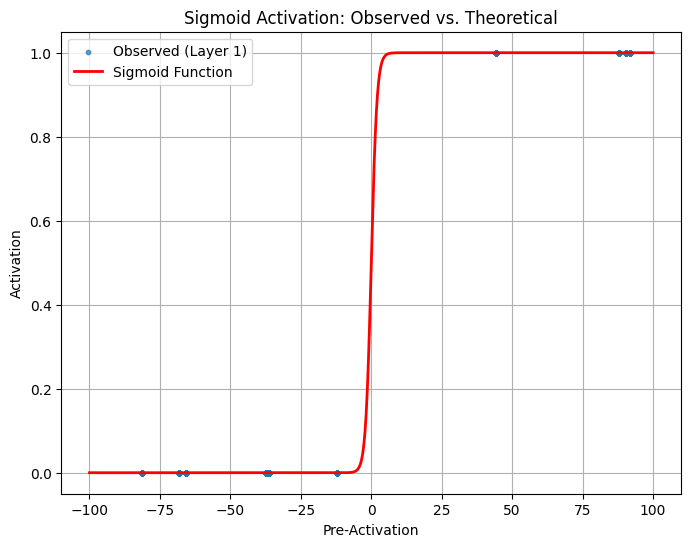

In [27]:
import numpy as np

# Store pre-activation and activation values for the first sigmoid layer
pre_activations = []
activations = []

# Modified forward pass to capture pre-activation and activation values
class DeepNetworkWithLogging(nn.Module):
    def __init__(self):
        super(DeepNetworkWithLogging, self).__init__()
        self.fc1 = nn.Linear(1, 10)  # First layer
        self.fc2 = nn.Linear(10, 10)  # Second layer
        self.fc3 = nn.Linear(10, 10)  # Third layer
        self.fc4 = nn.Linear(10, 10)  # Fourth layer
        self.fc5 = nn.Linear(10, 1)  # Fifth layer
        self.activation = nn.Sigmoid()  # Sigmoid activation

    def forward(self, x):
        pre_act = self.fc1(x)  # Pre-activation before first sigmoid
        act = self.activation(pre_act)  # Activation after sigmoid
        pre_activations.append(pre_act.detach().numpy().flatten())
        activations.append(act.detach().numpy().flatten())
        x = act  # Continue forward
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.fc4(x)
        x = self.activation(x)
        x = self.fc5(x)
        x = self.activation(x)
        return x

# Initialize the modified network
model = DeepNetworkWithLogging()

# Same training loop
for iteration in range(100):
    optimizer.zero_grad()
    output = model(x_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

# Flatten and aggregate pre-activation and activation values
pre_activations = np.concatenate(pre_activations)
activations = np.concatenate(activations)

# Generate sigmoid function for comparison
x_vals = np.linspace(-100, 100, 500)
sigmoid_vals = 1 / (1 + np.exp(-x_vals))

# Plot pre-activation vs. activation and sigmoid function
plt.figure(figsize=(8, 6))
plt.scatter(pre_activations, activations, s=10, label='Observed (Layer 1)', alpha=0.7)
plt.plot(x_vals, sigmoid_vals, label='Sigmoid Function', color='red', linewidth=2)
plt.xlabel('Pre-Activation')
plt.ylabel('Activation')
plt.title('Sigmoid Activation: Observed vs. Theoretical')
plt.legend()
plt.grid()
plt.show()


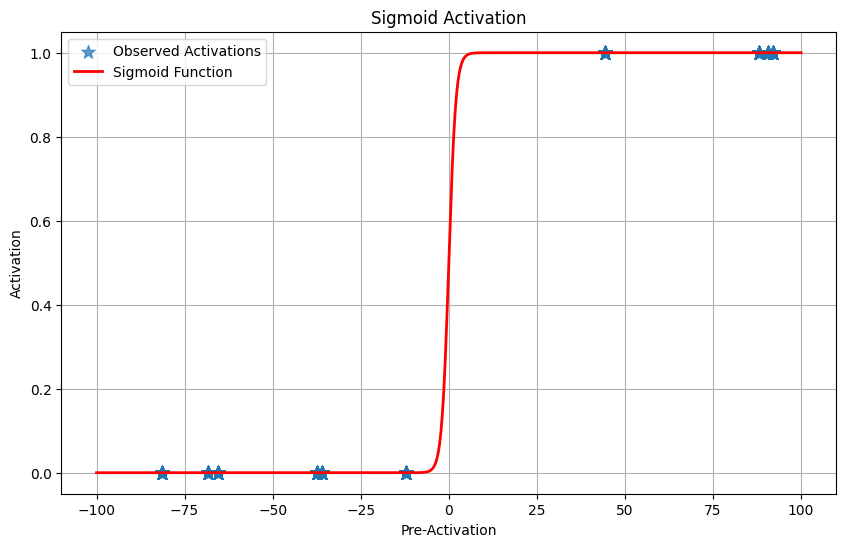

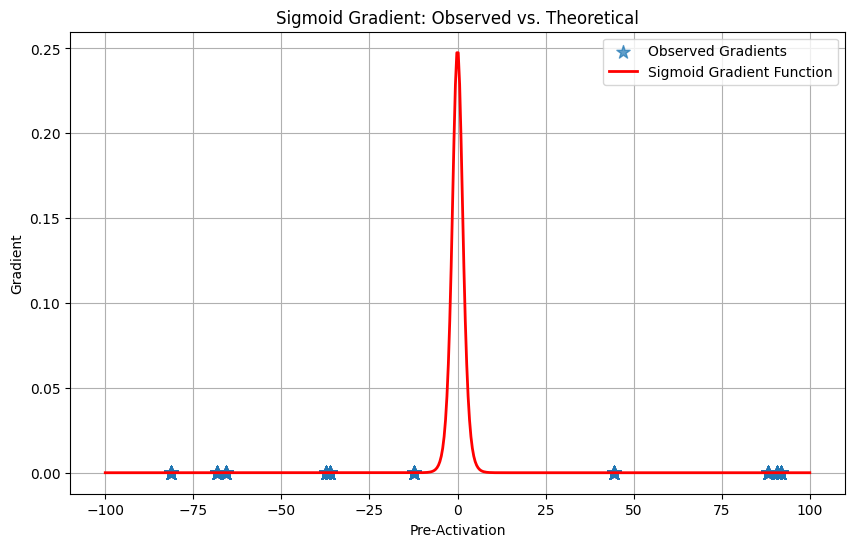

In [42]:
# Compute gradients for observed pre-activation data
pre_activation_gradients = activations * (1 - activations)  # Observed gradients of sigmoid

# Compute theoretical gradient of sigmoid
sigmoid_gradients = sigmoid_vals * (1 - sigmoid_vals)

# Plot the pre-activation vs. gradient and sigmoid gradient function
plt.figure(figsize=(10, 6))



# Observed activation vs. pre-activation
plt.scatter(pre_activations, activations, s=100, label='Observed Activations', alpha=0.7, marker='*')

# # Observed gradient vs. pre-activation
# plt.scatter(pre_activations, pre_activation_gradients, s=10, label='Observed Gradients', alpha=0.7, color='blue')

# Sigmoid function
plt.plot(x_vals, sigmoid_vals, label='Sigmoid Function', color='red', linewidth=2)

# Sigmoid gradient
# plt.plot(x_vals, sigmoid_gradients, label='Sigmoid Gradient', color='green', linestyle='--', linewidth=2)

plt.xlabel('Pre-Activation')
plt.ylabel('Activation')
plt.title('Sigmoid Activation')
plt.legend()
plt.grid()
plt.show()

# Plot sigmoid activation and its gradient on a single plot for comparison
plt.figure(figsize=(10, 6))
# Observed gradients (scatter plot)
plt.scatter(pre_activations, pre_activation_gradients, s=100, label='Observed Gradients', alpha=0.7, marker='*')

# Theoretical sigmoid gradient (line plot)
plt.plot(x_vals, sigmoid_gradients, label='Sigmoid Gradient Function', color='red', linewidth=2)

plt.xlabel('Pre-Activation')
plt.ylabel('Gradient')
plt.title('Sigmoid Gradient: Observed vs. Theoretical')
plt.legend()
plt.grid()
plt.show()



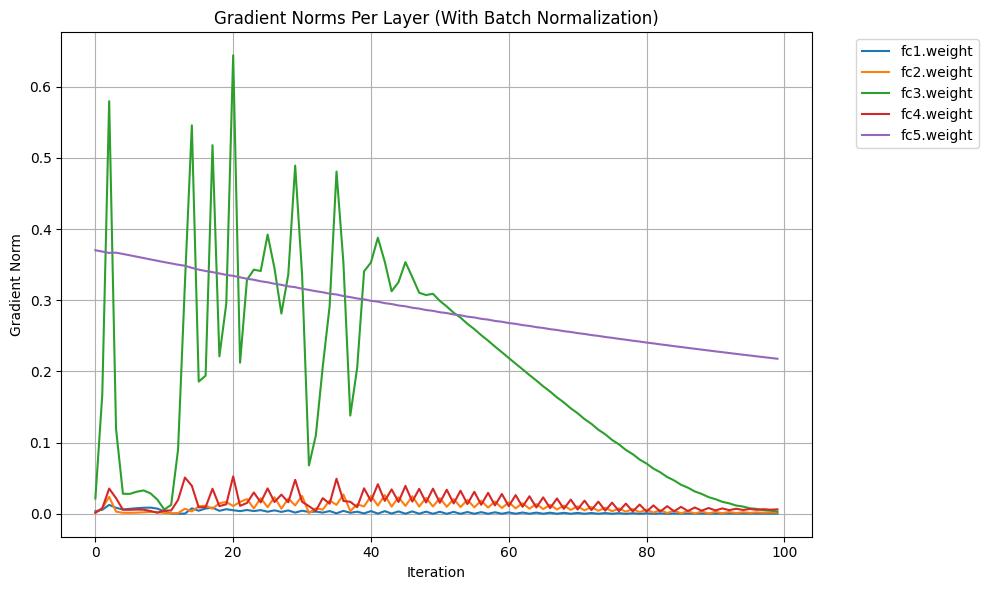

In [72]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Modified network with Batch Normalization
class DeepNetworkWithBatchNorm(nn.Module):
    def __init__(self):
        super(DeepNetworkWithBatchNorm, self).__init__()
        self.fc1 = nn.Linear(1, 10)  # First layer
        self.bn1 = nn.BatchNorm1d(10)  # BatchNorm for the first layer
        self.fc2 = nn.Linear(10, 10)  # Second layer
        self.bn2 = nn.BatchNorm1d(10)  # BatchNorm for the second layer
        self.fc3 = nn.Linear(10, 10)  # Third layer
        self.bn3 = nn.BatchNorm1d(10)  # BatchNorm for the third layer
        self.fc4 = nn.Linear(10, 10)  # Fourth layer
        self.bn4 = nn.BatchNorm1d(10)  # BatchNorm for the fourth layer
        self.fc5 = nn.Linear(10, 1)  # Fifth layer
        self.activation = nn.Sigmoid()  # Sigmoid activation

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                nn.init.orthogonal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.bn1(self.fc1(x))
        x = self.activation(x)
        x = self.bn2(self.fc2(x))
        x = self.activation(x)
        x = self.bn3(self.fc3(x))
        x = self.activation(x)
        x = self.bn4(self.fc4(x))
        x = self.activation(x)
        x = self.fc5(x)
        x = self.activation(x)
        return x


# Initialize the modified network
model = DeepNetworkWithBatchNorm()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Dummy training data
x_train = torch.rand(10, 1) *10.0  # Large input leads to sigmoid saturation
y_train = torch.tensor([[0.0]*10])  # Target

# To store gradient norms
gradient_norms = defaultdict(list)

# Training loop
for iteration in range(100):
    # Forward pass
    optimizer.zero_grad()
    output = model(x_train)
    loss = criterion(output, y_train)

    # Backward pass
    loss.backward()
    
    # Record gradient norm for each layer
    for name, param in model.named_parameters():
        if "bias" in name or "bn" in name: continue
        if param.grad is not None:
            gradient_norms[name].append(param.grad.norm(2).item())

    # Update weights
    optimizer.step()

# Plot the gradient norms for each layer
plt.figure(figsize=(10, 6))
for name, norms in gradient_norms.items():
    plt.plot(range(100), norms, label=name)

plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norms Per Layer (With Batch Normalization)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()


In [73]:
x_train

tensor([[9.2449],
        [1.5176],
        [6.2076],
        [2.6477],
        [2.9940],
        [0.5185],
        [4.4815],
        [3.4390],
        [1.7801],
        [4.9385]])

In [74]:
for key,values in gradient_norms.items():
    print(key, values[-1])

fc1.weight 0.00018350002937950194
fc2.weight 0.0015277923084795475
fc3.weight 0.0032197467517107725
fc4.weight 0.006261760368943214
fc5.weight 0.2178124189376831
